# Token Classification with Adapt𝒪r

This tutorial demonstrates a usage of Adapt𝒪r library for **Named Entity Recognition**, a Token Classification task.

In this scenario, Adapt𝒪r's Token Classification objective also conveniently deals with labels' per-token **alignment**, a reoccurring problem with identification of entities using the models based on sub-words tokenizers, e.g. Transformers.

This tutorial will show you:

1. The convenience of objective-centric training and evaluation, even in the single-objective token classification scenario.
2. The potential of a simple domain adaptation using Transformers, merely utilising the data of the training domain, that can be easily extended further with bigger corporas, matching the domain of application.
3. How can the states and methods of instances of Adapt𝒪r's objects be used for easy debugging or analyses.

#### Requirements

In [17]:
%%capture

!pip install --upgrade adaptor==0.1.4 datasets==2.1.0

### Dataset resolution

We will use publicly-available CoNLL 2003 dataset for Named Entity Recognition, annotated on the news articles from Reuters Corpus. See e.g. [paperswithcode.com](https://paperswithcode.com/dataset/conll-2003) for more info.

In [1]:
from datasets import load_dataset

conll_dataset = load_dataset("conll2003")
conll_dataset_nonempty = conll_dataset.filter(lambda sample: sample["tokens"])

Reusing dataset conll2003 (/home/xstefan3/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee/cache-fc8ea9d3f4217ca3.arrow
Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee/cache-8dba4962de85cab3.arrow
Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/63f4ebd1bcb7148b1644497336fd74643d4ce70123334431a3c053b7ee4e96ee/cache-0306437327e5464f.arrow


Transferring data to Adaptor's `TokenClassification` Objective format should be always easily-doable: for all existing objectives, the input format consists of a list of texts & labels, or a paths to a `.txt` files with one sample / label per line. See the base `Objective` docs.

If a different format suits your case better, all you might need is to override `_per_split_iterators(self, split: str) -> Tuple[Iterable[str], Iterable[str]]` for a selected top-level objective. This method returns a tuple of Iterables of samples and their aligned labels.

In [2]:
conll_texts = [" ".join(sample_tokens) for sample_tokens in conll_dataset_nonempty["train"]["tokens"]]
conll_val_texts = [" ".join(sample_tokens) for sample_tokens in conll_dataset_nonempty["validation"]["tokens"]]
conll_texts[:5]

['EU rejects German call to boycott British lamb .',
 'Peter Blackburn',
 'BRUSSELS 1996-08-22',
 'The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .',
 "Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer ."]

^^ this is a default input format of TokenClassification objective

To let the tuned transformer model remember the mapping of CoNLL's integer labels to their actual identifiers, we only need to map the integers to these identifiers and separate them with " ", (spaces). This way, each label correspond to a single word. 

In [3]:
label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}
label_map_sorted = dict(())

conll_labels = [" ".join(label_map[tag_id] for tag_id in sample) for sample in conll_dataset_nonempty["train"]["ner_tags"]]
conll_val_labels = [" ".join(label_map[tag_id] for tag_id in sample) for sample in conll_dataset_nonempty["validation"]["ner_tags"]]

conll_labels[:5]

['B-ORG O B-MISC O O O B-MISC O O',
 'B-PER I-PER',
 'B-LOC O',
 'O B-ORG I-ORG O O O O O O B-MISC O O O O O B-MISC O O O O O O O O O O O O O O',
 'B-LOC O O O O B-ORG I-ORG O O O B-PER I-PER O O O O O O O O O O O B-LOC O O O O O O O']

^^ this is a default format of the labels of TokenClassification objective

### Training setup

Using Adaptor, we compose our training process from the selected `Objective`s. This is fairly straight with a single fine-tuning Objective.
In addition, we can use an arbirary set of compatible `Evaluator`s. You can also define your own Evaluators (as shown later below).

Adaptor Objectives provide high-level interface, expecting both the input texts and labels in a form of:
* either a `List[str]`, with the texts and labels of the matching length
* or a paths to a `.txt` files with one sample / label per line.

In [ ]:
from adaptor.objectives.classification import TokenClassification
from adaptor.evaluators.token_classification import MeanPerCategoryFScore
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

ner_evaluators = [MeanFScore()]

ner_objective = TokenClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=conll_texts,
                                    labels_or_path=conll_labels,
                                    val_texts_or_path=conll_val_texts[:1000],
                                    val_labels_or_path=conll_val_labels[:1000],
                                    val_evaluators=ner_evaluators)

Once we are done with the datasets, objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [9]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="ner_training_checkpoints",
                                         stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         # log_level="critical",
                                         logging_steps=200,
                                         eval_steps=500,
                                         num_train_epochs=10,
                                         save_steps=1000)

comet_ml is installed but `COMET_API_KEY` is not set.


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

In [10]:
from adaptor.schedules import SequentialSchedule

schedule = SequentialSchedule(objectives=[ner_objective], args=training_arguments)

Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [11]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

Having the identical iterface, we initialize the training in the same way as with 🤗 Trainer

In [12]:
adapter.train()

***** Running training *****
  Num examples = 17550
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 43870
Converged objectives: []
TokenClassification:  46%|████▌     | 803/1755 [01:03<01:30, 10.57batches/s, epoch=1, loss=0.223, split=train]  

{'loss': 0.3426, 'learning_rate': 4.9772053795304315e-05, 'train_TokenClassification_loss': 0.34259614028735086, 'train_TokenClassification_num_batches': 800, 'epoch': 0.05}


TokenClassification:  91%|█████████▏| 1602/1755 [02:07<00:22,  6.71batches/s, epoch=1, loss=0.0128, split=train]

{'loss': 0.1504, 'learning_rate': 4.954410759060862e-05, 'train_TokenClassification_loss': 0.15091142149188091, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.09}


TokenClassification: 100%|██████████| 1755/1755 [02:21<00:00, 14.14batches/s, epoch=1, loss=0.00926, split=train]Converged objectives: []
TokenClassification: 1756batches [02:21, 12.41batches/s, epoch=1, loss=0.00254, split=train]                     
TokenClassification:  14%|█▍        | 243/1755 [00:19<01:50, 13.68batches/s, epoch=2, loss=0.571, split=train]  Evaluating...
***** Running Evaluation *****
  Num examples = 125
  Batch size = 1
TokenClassification: 1000batches [00:25, 39.86batches/s, epoch=2, loss=0.00392, split=eval]0.0117, split=train]
Converged objectives: []
TokenClassification:  14%|█▍        | 247/1755 [01:32<3:13:01,  7.68s/batches, epoch=2, loss=0.0133, split=train] 

{'eval_loss': 0.11448673903942108, 'eval_runtime': 25.0907, 'eval_samples_per_second': 318.844, 'eval_steps_per_second': 318.844, 'eval_TokenClassification_loss': 0.11448674616022618, 'eval_TokenClassification_num_batches': 1000, 'eval_TokenClassification_MeanPerCategoryFScore': 0.1062371446113906, 'epoch': 0.11}


TokenClassification:  37%|███▋      | 648/1755 [02:04<01:47, 10.34batches/s, epoch=2, loss=0.0857, split=train] 

{'loss': 0.0911, 'learning_rate': 4.931616138591293e-05, 'train_TokenClassification_loss': 0.09676574244932272, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.14}


TokenClassification:  82%|████████▏ | 1446/1755 [03:10<00:43,  7.06batches/s, epoch=2, loss=0.0185, split=train]

{'loss': 0.0727, 'learning_rate': 4.9088215181217234e-05, 'train_TokenClassification_loss': 0.07120190719582024, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.18}


TokenClassification: 100%|██████████| 1755/1755 [03:38<00:00, 14.12batches/s, epoch=2, loss=0.0022, split=train]  Converged objectives: []
TokenClassification: 1756batches [03:38,  8.05batches/s, epoch=2, loss=0.00155, split=train]                    
TokenClassification:  28%|██▊       | 488/1755 [00:39<01:17, 16.44batches/s, epoch=3, loss=0.00385, split=train] Converged objectives: []
Evaluating...
***** Running Evaluation *****
  Num examples = 125
  Batch size = 1


{'loss': 0.0464, 'learning_rate': 4.886026897652155e-05, 'train_TokenClassification_loss': 0.05340490972591215, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.23}


TokenClassification:   0%|          | 0/125 [03:32<?, ?batches/s, epoch=2, loss=-1, split=eval]
TokenClassification: 1000batches [00:24, 40.08batches/s, epoch=3, loss=0.000766, split=eval].00385, split=train]
Converged objectives: []
tokenizer config file saved in ner_training_checkpoints/checkpoint-1000/TokenClassification/tokenizer_config.json
Special tokens file saved in ner_training_checkpoints/checkpoint-1000/TokenClassification/special_tokens_map.json


{'eval_loss': 0.032869964838027954, 'eval_runtime': 24.9592, 'eval_samples_per_second': 320.524, 'eval_steps_per_second': 320.524, 'eval_TokenClassification_loss': 0.07367835350268433, 'eval_TokenClassification_num_batches': 2000, 'eval_TokenClassification_MeanPerCategoryFScore': 0.11058395881654728, 'epoch': 0.23}


Configuration saved in ner_training_checkpoints/checkpoint-1000/TokenClassification/config.json
Model weights saved in ner_training_checkpoints/checkpoint-1000/TokenClassification/pytorch_model.bin
TokenClassification:  74%|███████▎  | 1291/1755 [03:26<00:59,  7.79batches/s, epoch=3, loss=0.000707, split=train]

{'loss': 0.0391, 'learning_rate': 4.863232277182585e-05, 'train_TokenClassification_loss': 0.04019417429540772, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.27}


TokenClassification: 1756batches [04:06, 15.25batches/s, epoch=3, loss=0.00049, split=train]                      Converged objectives: []
TokenClassification: 1756batches [04:06,  7.11batches/s, epoch=3, loss=0.00049, split=train]
TokenClassification:  19%|█▉        | 334/1755 [00:26<03:26,  6.87batches/s, epoch=4, loss=0.215, split=train]

{'loss': 0.0333, 'learning_rate': 4.840437656713016e-05, 'train_TokenClassification_loss': 0.03447006914763188, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.32}


TokenClassification:  42%|████▏     | 732/1755 [00:56<01:11, 14.35batches/s, epoch=4, loss=0.000473, split=train]Evaluating...
***** Running Evaluation *****
  Num examples = 125
  Batch size = 1
TokenClassification:   0%|          | 0/125 [03:58<?, ?batches/s, epoch=3, loss=-1, split=eval]
TokenClassification: 1000batches [00:25, 39.77batches/s, epoch=4, loss=0.000602, split=eval].000473, split=train]
TokenClassification: 100%|██████████| 1755/1755 [03:57<00:00, 14.76batches/s, epoch=7, loss=0.000133, split=train]Converged objectives: []
TokenClassification: 1756batches [03:57,  7.40batches/s, epoch=7, loss=0.000174, split=train]                     
TokenClassification:  29%|██▉       | 512/1755 [00:40<02:06,  9.82batches/s, epoch=8, loss=0.000339, split=train]

{'loss': 0.0067, 'learning_rate': 4.6352860724868935e-05, 'train_TokenClassification_loss': 0.0077938092411204704, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.73}


TokenClassification:  75%|███████▍  | 1310/1755 [01:44<00:47,  9.35batches/s, epoch=8, loss=0.0107, split=train]  

{'loss': 0.0077, 'learning_rate': 4.612491452017324e-05, 'train_TokenClassification_loss': 0.0075396578505533395, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.77}


TokenClassification:  97%|█████████▋| 1707/1755 [02:18<00:04, 10.91batches/s, epoch=8, loss=0.000394, split=train]Evaluating...
***** Running Evaluation *****
  Num examples = 125
  Batch size = 1
TokenClassification:   0%|          | 0/125 [03:52<?, ?batches/s, epoch=7, loss=-1, split=eval]
TokenClassification: 1000batches [00:25, 39.74batches/s, epoch=8, loss=0.000123, split=eval]0.102, split=train]   
Converged objectives: []
TokenClassification:  97%|█████████▋| 1710/1755 [03:31<06:46,  9.04s/batches, epoch=8, loss=0.000161, split=train]

{'eval_loss': 0.006507412530481815, 'eval_runtime': 25.1699, 'eval_samples_per_second': 317.84, 'eval_steps_per_second': 317.84, 'eval_TokenClassification_loss': 0.02726664596444581, 'eval_TokenClassification_num_batches': 7000, 'eval_TokenClassification_MeanPerCategoryFScore': 0.11259841086486444, 'epoch': 0.8}


TokenClassification: 1756batches [03:35, 13.49batches/s, epoch=8, loss=0.000184, split=train]                     Converged objectives: []
TokenClassification: 1756batches [03:35,  8.16batches/s, epoch=8, loss=0.000184, split=train]
TokenClassification:  20%|██        | 354/1755 [00:29<03:29,  6.69batches/s, epoch=9, loss=0.0188, split=train]

{'loss': 0.0072, 'learning_rate': 4.5896968315477554e-05, 'train_TokenClassification_loss': 0.007918790022467875, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.82}


TokenClassification:  66%|██████▌   | 1156/1755 [01:31<01:02,  9.54batches/s, epoch=9, loss=0.000517, split=train]

{'loss': 0.0052, 'learning_rate': 4.566902211078185e-05, 'train_TokenClassification_loss': 0.005010867099506868, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.87}


TokenClassification: 1756batches [02:15, 16.91batches/s, epoch=9, loss=9.97e-5, split=train]                      Converged objectives: []
TokenClassification: 1756batches [02:15, 12.98batches/s, epoch=9, loss=9.97e-5, split=train]
TokenClassification:  11%|█         | 195/1755 [00:13<01:58, 13.11batches/s, epoch=10, loss=9.25e-5, split=train] Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS
Evaluating...
***** Running Evaluation *****
  Num examples = 125
  Batch size = 1


{'loss': 0.0069, 'learning_rate': 4.5441075906086166e-05, 'train_TokenClassification_loss': 0.0064484594378245675, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.91}


TokenClassification:  11%|█         | 196/1755 [00:24<01:58, 13.11batches/s, epoch=10, loss=0.000163, split=train]Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS
tokenizer config file saved in ner_training_checkpoints/checkpoint-4000/TokenClassification/tokenizer_config.json
Special tokens file saved in ner_training_checkpoints/checkpoint-4000/TokenClassification/special_tokens_map.json


{'eval_loss': 0.00012769266322720796, 'eval_runtime': 0.0302, 'eval_samples_per_second': 265.095, 'eval_steps_per_second': 265.095, 'eval_TokenClassification_loss': 0.027262769524894145, 'eval_TokenClassification_num_batches': 7001, 'eval_TokenClassification_MeanPerCategoryFScore': 0.11273161205067099, 'epoch': 0.91}


Configuration saved in ner_training_checkpoints/checkpoint-4000/TokenClassification/config.json
Model weights saved in ner_training_checkpoints/checkpoint-4000/TokenClassification/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Scheduler reached the given maximum number of epochs for all objectives. Triggering termination.
Scheduler reached a termination condition: ALL_OBJECTIVES_NUM_EPOCHS


{'train_runtime': 1951.3271, 'train_samples_per_second': 89.939, 'train_steps_per_second': 22.482, 'train_loss': 0.0467430756688118, 'train_TokenClassification_loss': 0.0064484594378245675, 'train_TokenClassification_num_batches': 1000, 'epoch': 0.91}


TrainOutput(global_step=4000, training_loss=0.0467430756688118, metrics={'train_runtime': 1951.3271, 'train_samples_per_second': 89.939, 'train_steps_per_second': 22.482, 'total_flos': 0.0, 'train_loss': 0.0467430756688118})

The training terminates when the selected `StoppingStrategy` is satisfied. There is a slightly larger list of options to pick from, to cover the wider variety of multi-objective situations. See the [StoppingStrategy options](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L19).

### Display logs

Objectives have **states** that remember their most-recent evaluations, that you can directly use to verify Objective's convergence, or accuracy

However, it might be more convenient to use **external logging** tool like *Tensorboard*, *Comet.ml*, or *Weights & Biases*, that will also track other info for you. You can (and are encouraged to) use any logging tools supported by 🤗  Transformers; see [here](https://huggingface.co/docs/transformers/main_classes/logging).

In [21]:
ner_objective.evaluations_history['eval'].keys()

dict_keys([<adaptor.evaluators.token_classification.MeanFScore object at 0x7f720bdb9a20>, 'loss'])

<AxesSubplot:>

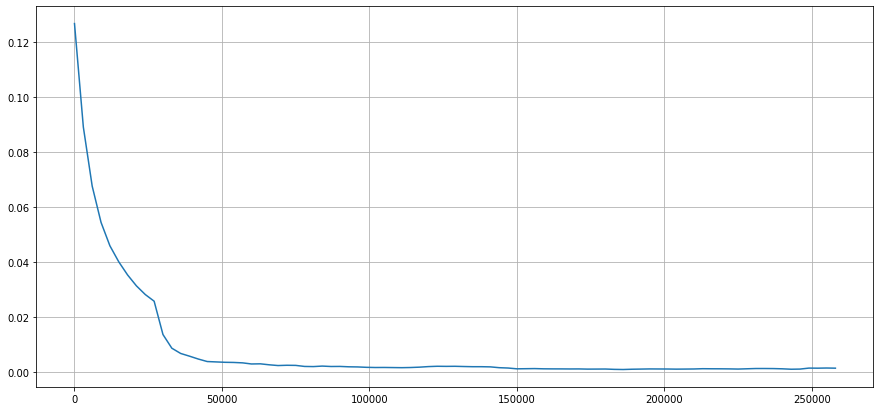

In [101]:
import pandas as pd

total_logs = len(ner_objective.evaluations_history["eval"]["loss"])
training_steps = ner_objective.num_steps

index = range(0, training_steps, training_steps // total_logs)

pd.Series(ner_objective.evaluations_history["eval"]["loss"], index=index).plot(figsize=(15, 7), grid=True)

### Save the trained model

After the training finishes, we persist the model.

In [ ]:
# 5. save the trained lang_module (with all heads)
adapter.save_model("entity_detector_model")

In [ ]:
! ls entity_detector_model

This is slightly different with Adaptor's `Adapter` as with 🤗  Transformers: instead of a single model, the `save_model` will produce a separate model for each `Objective`. Even though the most parameters of the trained multi-head model are shared, thanks to this, you can entirely get rid of the dependency on Adaptor, as each of the models can be reloaded using Transformers' `AutoModelForXY.from_pretrained("save_model_path/objective_name")`:

In [4]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

ner_model = AutoModelForTokenClassification.from_pretrained("entity_detector_model/TokenClassification")
tokenizer = AutoTokenizer.from_pretrained("entity_detector_model/TokenClassification")

Objectives also take care of the correct configuration of the persisted model

In [5]:
ner_model.config.id2label

{0: 'B-LOC',
 1: 'B-MISC',
 2: 'B-ORG',
 3: 'B-PER',
 4: 'I-LOC',
 5: 'I-MISC',
 6: 'I-ORG',
 7: 'I-PER',
 8: 'O'}

## Model usage

The reloaded model can be used rightaway as follows:

In [ ]:
inputs = tokenizer("Is there any Abraham Lincoln here?", return_tensors="pt")
outputs = ner_model(**inputs)
ner_tags = [ner_model.config.id2label[label_id.item()] for label_id in outputs.logits[0].argmax(-1)]

# Evaluation

To obtain a representative evaluation of our freshly-trained model, we'll evaluate it in a held-out (test) set of CoNLL.

To avoid a boilerplate implementation of Wordpiece-to-labels alignment, we'll also use the TokenClassification objective here, but if you prefer to completely avoid Adaptor in evaluation, take a look at [how it's done](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/objectives/classification.py#L14) in TokenClassfication and implement it in a standalone.

Additionally, we'll see that defining a custom `Evaluator` in Adaptor is usually fairly simple. Here, we define a custom `AverageAccuracy` measure and report the results of our TokenClassification Objective on this new measure.

### Testing dataset

In [4]:
conll_test_texts = [" ".join(sample_tokens) for sample_tokens in conll_dataset_nonempty["test"]["tokens"]]

In [5]:
# we load the data again from CoNLL, so the mapping is different than in our Objective -> we transform them to universal identifier format

label_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}

conll_test_labels = [" ".join(label_map[tag_id] for tag_id in sample) for sample in conll_dataset_nonempty["test"]["ner_tags"]]

### Custom Evaluators

Now we define a custom evaluation measure that we'll report on. There is a good bunch of different approaches on how to aggregate token-level predictions. Our `AverageAccuracy` implements a global token-level accuracy.

When implementing a new Evaluator in Adaptor, it's a good idea to take a look at existing evaluator of the same category and its superclass, and utilise the methods of the highest level that are still useful for you.

In this case, we find that `TokenClassificationEvaluator` superclass has correct `compatible_heads` and a convenient implementation of `_collect_token_predictions` method. All that's left to do is to produce the desired statistics on the flattened token-level predictions.

In [16]:
from adaptor.evaluators.token_classification import TokenClassificationEvaluator

class AverageAccuracy(TokenClassificationEvaluator):

    def __call__(self, 
                 model: "torch.nn.Module",
                 tokenizer: "PreTrainedTokenizer",
                 dataset: "AdaptationDataset",
                 ignored_index: int = -100) -> float:

        expected, actual = self._collect_token_predictions(model, dataset)

        num_matching = sum(e_i == a_i for e_i, a_i in zip(expected, actual) if e_i != ignored_index)
        num_all = sum(e_i != ignored_index for e_i in expected)

        return num_matching / num_all

Given a custom Evaluator, we initialise the `TokenClassification` objective identically as when training, we just replace the `val_texts_or_path` and `val_labels_or_path` with the test resources and add an instance of `AverageAccuracy` to a list of evaluators.

In [ ]:
from adaptor.lang_module import LangModule
from adaptor.objectives.classification import TokenClassification

ner_evaluators = [AverageAccuracy()]

lang_module = LangModule("entity_detector_model/TokenClassification")


test_ner_objective = TokenClassification(lang_module,
                                         batch_size=8,
                                         texts_or_path=[],
                                         labels_or_path=[],
                                         val_texts_or_path=conll_test_texts[:1000],
                                         val_labels_or_path=conll_test_labels[:1000],
                                         val_evaluators=ner_evaluators)

We can use `evaluate` for evaluating on a single objective. During the training, this method is called by `Schedule`, but can be conveniently used also for computing test evaluation. Feel free to take a look at its [documentation](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/objectives/objective_base.py#L135) in base Objective implementation.

In [15]:
evaluations = test_ner_objective.evaluate("eval")

evaluations

TokenClassification: 100%|██████████| 125/125 [00:18<00:00,  5.36batches/s, epoch=0, loss=-1, split=eval]

{'eval_TokenClassification_loss': 0,
 'eval_TokenClassification_num_batches': 0,
 'eval_TokenClassification_AverageAccuracy': 0.9574836867862969}

In [16]:
evaluations["eval_TokenClassification_AverageAccuracy"]

0.9574836867862969

So that means that our model correctly assigned appx. 95% of tokens into one of 9 categories. Not bad.

## Adaptation

Finally, we'll take a look at how can we **improve** a quality of NER model with **adaptation**, using Adaptor.

In addition to the final task, we'll first adapt the model using unsupervised `MaskedLanguageModeling`. This objective is commonly used approach to pre-train the encoders like BERT on a vast amounts of unsupervised texts and makes them able to fit the supervised tasks **faster** afterwards. Continuing in such pre-training is also the most basic adaptation scenario.

We'll show how to do this using Adaptor here.

In [6]:
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

We proceed identically as in the former case, but we add a `MaskedLanguageModeling` objective, fitted on the same training data into the `SequentialSchedule`.

In [7]:
from adaptor.objectives.MLM import MaskedLanguageModeling

mlm_adaptation = MaskedLanguageModeling(lang_module,
                                        batch_size=32,
                                        texts_or_path=conll_texts)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Though `TokenClassification` objective is identical to the previous case.

In [8]:
from adaptor.objectives.classification import TokenClassification
from adaptor.evaluators.token_classification import MeanFScore

ner_evaluators = [MeanFScore(decides_convergence=True)]

ner_objective = TokenClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=conll_texts,
                                    labels_or_path=conll_labels,
                                    val_texts_or_path=conll_val_texts[:1000],
                                    val_labels_or_path=conll_val_labels[:1000],
                                    val_evaluators=ner_evaluators)

training_objectives = [mlm_adaptation, ner_objective]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [9]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="ner_training_checkpoints",
                                         stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         # log_level="critical",
                                         logging_steps=200,
                                         eval_steps=500,
                                         num_train_epochs=10,
                                         save_steps=1000)

comet_ml is installed but `COMET_API_KEY` is not set.


In [10]:
from adaptor.schedules import SequentialSchedule

schedule = SequentialSchedule(objectives=training_objectives, args=training_arguments)

Total number of train samples: 28082
Total number of eval samples: 1000


In [11]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

In [ ]:
adapter.train()  # the training is quite long here, so we cleaned the outputs logs

In [14]:
adapter.save_model("mlm_adapted_ner_model")

tokenizer config file saved in mlm_adapted_ner_model/MaskedLanguageModeling/tokenizer_config.json
Special tokens file saved in mlm_adapted_ner_model/MaskedLanguageModeling/special_tokens_map.json
Configuration saved in mlm_adapted_ner_model/MaskedLanguageModeling/config.json
Model weights saved in mlm_adapted_ner_model/MaskedLanguageModeling/pytorch_model.bin
tokenizer config file saved in mlm_adapted_ner_model/TokenClassification/tokenizer_config.json
Special tokens file saved in mlm_adapted_ner_model/TokenClassification/special_tokens_map.json
Configuration saved in mlm_adapted_ner_model/TokenClassification/config.json
Model weights saved in mlm_adapted_ner_model/TokenClassification/pytorch_model.bin


As a main evaluation metric, we again use our newly-implemented `AverageAccuracy`, and proceed identically.

In [17]:
ner_evaluators = [AverageAccuracy()]

adapted_lang_module = LangModule("mlm_adapted_ner_model/TokenClassification")

test_ner_objective = TokenClassification(adapted_lang_module,
                                         batch_size=8,
                                         texts_or_path=[],
                                         labels_or_path=[],
                                         val_texts_or_path=conll_test_texts[:1000],
                                         val_labels_or_path=conll_test_labels[:1000],
                                         share_other_objective_head=ner_objective,
                                         val_evaluators=ner_evaluators)

Didn't find file mlm_adapted_ner_model/TokenClassification/added_tokens.json. We won't load it.
loading file mlm_adapted_ner_model/TokenClassification/vocab.txt
loading file mlm_adapted_ner_model/TokenClassification/tokenizer.json
loading file None
loading file mlm_adapted_ner_model/TokenClassification/special_tokens_map.json
loading file mlm_adapted_ner_model/TokenClassification/tokenizer_config.json
Objective TokenClassification will use TOKEN_CLASSIFICATION head of TokenClassification objective


In [18]:
evaluations = test_ner_objective.evaluate("eval")
evaluations["eval_TokenClassification_AverageAccuracy"]

TokenClassification:  98%|█████████▊| 123/125 [00:03<00:00, 41.30batches/s, epoch=0, loss=-1, split=eval]

0.9633462479608483

TokenClassification: 100%|██████████| 125/125 [00:14<00:00, 41.30batches/s, epoch=0, loss=-1, split=eval]

And we got a gain of **0.6%** of accuracy!

It's not much, but you can also say, that thanks to adaptation, we've **eliminated more than 10% of the remaining error** of the model for free, without any additional data. Sounds like a free lunch, right?


*****************
In this tutorial, we have shown the benefits of objective-centric approach to training language models on a common task of Named Entity Recognition. You could have seen that transferring from conventional single-objective training to multi-objective adaptation is a three-liner with the initialisation of one extra objective.

In the more interesting scenarios, you might want to try to use **external datasets** and **auxiliary tasks** from other **similar domain**. In the low-resource scenarios, it might also be interesting to try to train multi-head model on **complementary supervised data**.